# Doing this from scratch

In [5]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 8*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Autosaving every 180 seconds


In [172]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
# idx = 800 
# fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
# pc1 = np.load(fn1)
# pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention

# #KITTI-CARLA
# town = 'Town02'
# idx = 0
# s1_fn = '/home/derm/KITTICARLA/dataset/' + town + '/generated/frames/frame_%04d.ply' %(idx)
# dat1 = trimesh.load(s1_fn)
# pc1 = dat1.vertices
# pc1 = pc1[:140_224]
# noise_scale = 0.02 #need to add some noise or numerics can cause VICET and NDT to get stuck
# pc1 += noise_scale*np.random.randn(np.shape(pc1)[0],3)

#TODO: trim synthetic data to [0,2pi] theta

# synthetic LIDAR data (VICET paper)
fn1 = "raw_frame_1.npy"
pc1 = np.load(fn1)

# fn1 = "/home/derm/ASAR/v3/point_cloud_rectification/sample_data/test2/raw_frame_1.npy"
# pc1 = np.load(fn1)
# #remove inf values
# pc1[pc1[:,0]>100] = 0
# pc1[pc1[:,0]<-100] = 0
# # noise_scale = 0.02 #need to add some noise or numerics can cause VICET and NDT to get stuck
# # pc1 += noise_scale*np.random.randn(np.shape(pc1)[0],3)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
# color = pc1_spherical[:,0] * 4
# print(color)

cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

# test = pc1[::64]
# # # test = test[::64]
# disp.append(Points(test, c='red',r = 5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

674.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image


In [178]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi] --> theta = azimuth, phi = elevation
print(np.shape(pc1_spherical))

depth_image = np.zeros([64, len(pc1_spherical)//64])
# print(np.shape(depth_image))

# #nope?
# #sort pc1_spherical by azim and elevation angles
# pc1_spherical = np.reshape(pc1_spherical, [1024,64,-1])[:,:,0].T
# print(np.shape(pc1_spherical))

#set points of radius zero (i.e. non returns) to large values
depth_image = pc1_spherical.copy()
non_return_idx = np.argwhere(depth_image == 0)
# print(non_return_idx)
depth_image[non_return_idx[:,0], non_return_idx[:,1]] = 10

(86272, 3)


In [174]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
# pc1_spherical = LC.c2s(LC,new_point_cloud_cart).numpy() #[r, theta, phi] 
pcs = np.reshape(pc1_spherical, [-1,64,3])
print(np.shape(pcs))
pcs = np.flip(pcs, axis = 1)

# pcs = pcs[np.argsort(pcs, axis = 1)[:,0,0]]
# print(np.shape(pcs))

(1348, 64, 3)


<IPython.core.display.Javascript object>


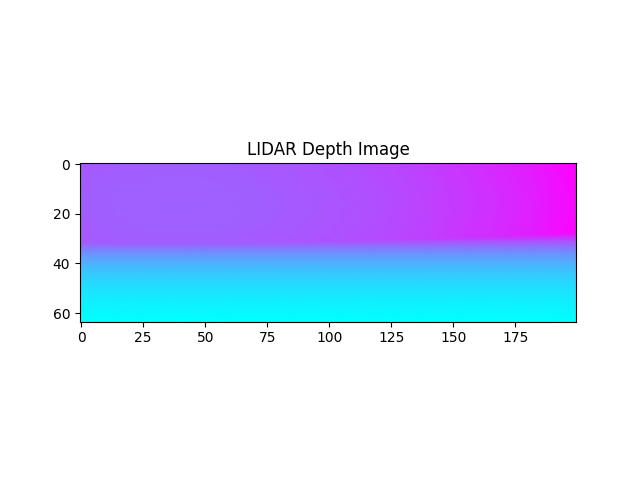

In [175]:
fig, ax = p.subplots()
ax.set_title("LIDAR Depth Image")
data = pcs[650:850,:,0].T
# data = (data)%10 #add zebra stripes to make it easier to visualize depth
p.imshow(data, cmap = "cool", norm='linear')

# Reproject 2D Depth image back to 3D point cloud using same convention

In [176]:
#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(pcs)[0]):
    for h in range(np.shape(pcs)[1]):
        new_point_cloud_spherical[count,0] = pcs[w,h,0] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(pcs)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(pcs)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
print(np.shape(new_point_cloud_cart))
print(new_point_cloud_cart)

(86272, 3)
[[10.03245209  0.          1.8902115 ]
 [10.01619215  0.          1.77046251]
 [10.03319478  0.          1.6570493 ]
 ...
 [ 3.19645479 -0.01489916 -1.75236157]
 [ 3.13470468 -0.01461133 -1.76475803]
 [ 3.0063983  -0.01401327 -1.73744761]]


In [177]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))
disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert KITTI-CARLA cloud to 64x2177 depth image

In [ ]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
# pcs = np.reshape(pc1_spherical, [-1,64,3])
# print(np.shape(pcs))
# pcs = np.transpose(pcs, [1,0,2])
# pcs = np.reshape(pc1_spherical, [-1,64,3])

count = 0
pcs = np.zeros([64,2177,3])
for w in range(2177):
    for h in range(64):
        pcs[h,w] = pc1_spherical[count,:]
        count+=1
        
# pcs = np.reshape(pc1_spherical,[64,-1,3])
# # pcs = np.transpose(np.reshape(pc1_spherical, [-1,64,3]), [1,0,2]).reshape([64,-1,3])
# pc1_cart_test = np.reshape(pcs, [-1,3])
# pc1_cart_test = LC.s2c(LC, pc1_cart_test).numpy()

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]

# ## purple -> green
# color = 255*np.linspace(0,1,len(pc1_cart_test)) 
# cname = np.array([255-color, color, 255-color]).T.tolist()
# disp.append(Points(pc1_cart_test, c=cname,  r = 3.5, alpha =0.5))
# print(len(pc1) / 128)

# # test = pc1[::64]
# # # test = test[::64]

# # disp.append(Points(test, c='red',r = 5))

# plt.show(disp, "01 Short Experiment Frame #" + str(idx))
# ViewInteractiveWidget(plt.window)


<IPython.core.display.Javascript object>


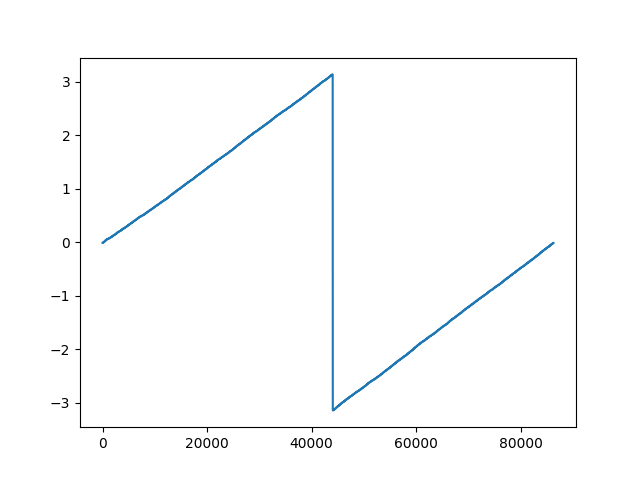

In [181]:
fig, ax = p.subplots()
ax.plot(pc1_spherical[:,1])

# test = np.reshape(pcs, [-1,3])
# ax.plot(test[:,1])

In [ ]:
a = np.array([[[9, 2, 3],
               [4, 5, 6],
               [7, 0, 5]],
               [[2, 4, 6],
               [4, 5, 3],
               [1, 9, 2]]])
a = a.T 
print(a) #3x3x2

# a.sort(axis = 0)
print("---- \n")

a = a[np.argsort(a, axis = 0)[:,0,0]]
print(a)

a = np.transpose(a, [1,0,2])
a = a[np.argsort(a, axis = 0)[:,0,0]]
a = np.transpose(a, [1,0,2])
print("--- \n ", a)


In [ ]:
a = np.linspace(0,11,12)
a = np.array([a,a,a]).T
print(a, "\n ------------")
b = np.reshape(a, [2,6,3])
print(b,"\n -----------")

c = np.transpose(np.reshape(a, [6,2,3]), [1,0,2]).reshape([2,6,3])
print("\n",c)

In [ ]:
a = np.linspace(0,17,18)
print(a, "\n")
b = np.reshape(a, [3,6])
print(b)

c = np.reshape(a, [6,3]).T.reshape([3,6])
print("\n",c)